In [1]:
#load data from files
from PIL import Image
import os, os.path
import glob
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader 
from sklearn import preprocessing as pc


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
transform = transforms.Compose(
    [transforms.Resize((150,150)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

labels_dic = {"buildings": 0, "forest": 1, "glacier" : 2, "mountain" : 3, "sea" : 4, "street" : 5}
encoder = {0: "buildings", 1: "forest", 2 : "glacier", 3 : "mountain", 4: "sea", 5: "street"}

def load_data(data):
    images = []
    classes = ["building", "forest", "glacier", "mountain", "sea", "street"]
    labels = []
    for i in classes:
        path = os.path.join((f"./dataset/{data}"),i)
        path += "/*.jpg"
        for file in glob.glob(path):
            labels.append(labels_dic[i])
            im = Image.open(file)
            images.append(transform(im))
            im.close()
    return images, labels


#take big ass chucnk of data test_x
#shuffle data
train_set = load_data("train")



In [4]:
#split data
size = 100
shuffle_iters = len(train_set[0])/size

def split_data(data_set): 
    pile = []
    i = 0
    while i < len(data_set):
        if (len(data_set) - size) < size:
            pile.append(data_set[i:i+len(data_set)])
           #break
        pile.append(data_set[i:i+size])
        i += size
    return pile

trainset_x = split_data(train_set[0])
trainset_y = split_data(train_set[1])


In [5]:
#shuffle data 
def shuffle_data(data_set):
    size = int(len(data_set)/2)
    result_data = []
    counter_x = 0
    counter_y = size
    for i in range(size):
        x = data_set[counter_x]
        y = data_set[counter_y]
        result_data.append(y)
        result_data.append(x)
        counter_x += 1
        counter_y += 1
    return result_data
    
trainset_x = shuffle_data(trainset_x)
trainset_y = shuffle_data(trainset_y)

In [6]:
def flatten_x(l):
    data_x = []
    for i in l:
        data_x += i
    return data_x
    
train_x = flatten_x(trainset_x)

def flatten_y(l):
    return [item for sublist in l for item in sublist] #stackoverflow provieds nicest list comprehensions 

train_y = flatten_y(trainset_y)

In [7]:
class Mydata(Dataset):
    
    def __init__(self, x, y): 
        self.x = x
        self.y = y
        self.len = len(x)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.x[idx] , self.y[idx]
        

In [8]:
trainset = Mydata(train_x, train_y)

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv1 = nn.Conv2d(3, 6, 6)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.conv3 = nn.Conv2d(12, 24, 3)
        self.conv4 = nn.Conv2d(24, 12, 3)
        self.fc1 = nn.Linear(588, 244)
        self.fc2 = nn.Linear(244, 6)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool1(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #fully connected Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Net()

In [10]:
if torch.cuda.is_available():
    model.cuda()
import torch.optim as optim

lr = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

In [12]:
n_iters = 20

for epoch in range(n_iters):
    Loss = []
    print(f"\n-----epoch:{epoch+1}-----\n")
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out,labels)
        loss.backward()
        optimizer.step()
        if i % 10 == 0: 
            print(f"running_loss: {loss.item()}")
      #print(inputs.shape)
    Loss.append(loss.item())
    print(f"\n loss_model: {sum(Loss)/len(Loss)}")


-----epoch:1-----

running_loss: 1.7998161315917969
running_loss: 1.589583158493042
running_loss: 1.266858696937561
running_loss: 1.0228931903839111
running_loss: 1.009373426437378
running_loss: 1.0201294422149658
running_loss: 0.9540987610816956
running_loss: 0.784099817276001
running_loss: 1.0710543394088745
running_loss: 1.0118101835250854
running_loss: 0.8769830465316772
running_loss: 0.8404551148414612

 loss_model: 0.9926261305809021

-----epoch:2-----

running_loss: 0.8442928194999695
running_loss: 0.7919766306877136
running_loss: 0.8320675492286682
running_loss: 0.8478043079376221
running_loss: 0.98211270570755
running_loss: 0.9338610768318176
running_loss: 0.8847571611404419
running_loss: 0.8257501721382141
running_loss: 0.7072792649269104
running_loss: 0.7312979102134705
running_loss: 0.6933773756027222
running_loss: 0.7206282615661621

 loss_model: 0.8309004306793213

-----epoch:3-----

running_loss: 0.8585695624351501
running_loss: 0.7151486873626709
running_loss: 0.742624

running_loss: 0.2544877827167511
running_loss: 0.4911107122898102
running_loss: 0.24159212410449982
running_loss: 0.29591959714889526
running_loss: 0.3469170331954956
running_loss: 0.41429993510246277
running_loss: 0.34319061040878296
running_loss: 0.33450257778167725
running_loss: 0.2579007148742676
running_loss: 0.3141457736492157

 loss_model: 0.37768280506134033

-----epoch:20-----

running_loss: 0.3778797388076782
running_loss: 0.3254860043525696
running_loss: 0.2363448143005371
running_loss: 0.28228560090065
running_loss: 0.21776436269283295
running_loss: 0.26216524839401245
running_loss: 0.3713914752006531
running_loss: 0.32534754276275635
running_loss: 0.20083323121070862
running_loss: 0.21907411515712738
running_loss: 0.24988989531993866
running_loss: 0.3200521767139435

 loss_model: 0.2762882709503174


In [13]:
# load, split, shuffle test_data
batch_size = 500
test_set = load_data("test")
testset_x = split_data(test_set[0])
testset_y = split_data(test_set[1])
testset_x = shuffle_data(testset_x)
testset_y = shuffle_data(testset_y)
test_x = flatten_x(testset_x)
test_y = flatten_y(testset_y)
testset = Mydata(test_x, test_y)

testloader = DataLoader(testset, batch_size=batch_size , shuffle=False)

In [14]:
#testing accuracy 
total = 0
correct = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, out_hat = torch.max(out , 1)
        total += labels.size(0)
        correct += (out_hat == labels).sum().item()
print(f'Accuracy of the Model: {(100 * correct / total):.2f}%')

Accuracy of the Model: 85.88%


In [15]:
#Not bad i think, but we 
#have very low loss while accuracy isn't extremly high -> overfitting , 81% seems fine though 
#still overfiting but much better results than before, shuffeling data and reducing the cnn size helped
#With data augmentation we could try to improve over all accuracy 

In [16]:
#loading data for prediction, they are not labeld 
def load_data_pred():
    images = []
    labels = []
    path = ("./dataset/pred/*jpg")
    for file in glob.glob(path):
        im = Image.open(file)
        images.append(transform(im))
        im.close()
        labels.append(0)
    return images,labels


pred_set = load_data_pred()

class Data_pred(Dataset):
    
    def __init__(self, data): 
        self.x = data[0]
        self.y = data[1]
        self.len = len(data[0])
    
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.x[idx] , self.y[idx]
    
pred_data = Data_pred(pred_set)

In [17]:
preddataloader = DataLoader(pred_data, batch_size=20, shuffle=True)

In [18]:
import matplotlib.pyplot as plt
import numpy as np

labels_predicted = []

inputs_pred, labels_pred = next(iter(preddataloader))
inputs_pred, labels_pred = inputs_pred.to(device), labels_pred.to(device)
out = model(inputs_pred)
_, out_hat = torch.max(out, 1)


labels_predicted = [encoder[out_hat[i].item()] for i in range(len(out_hat))]

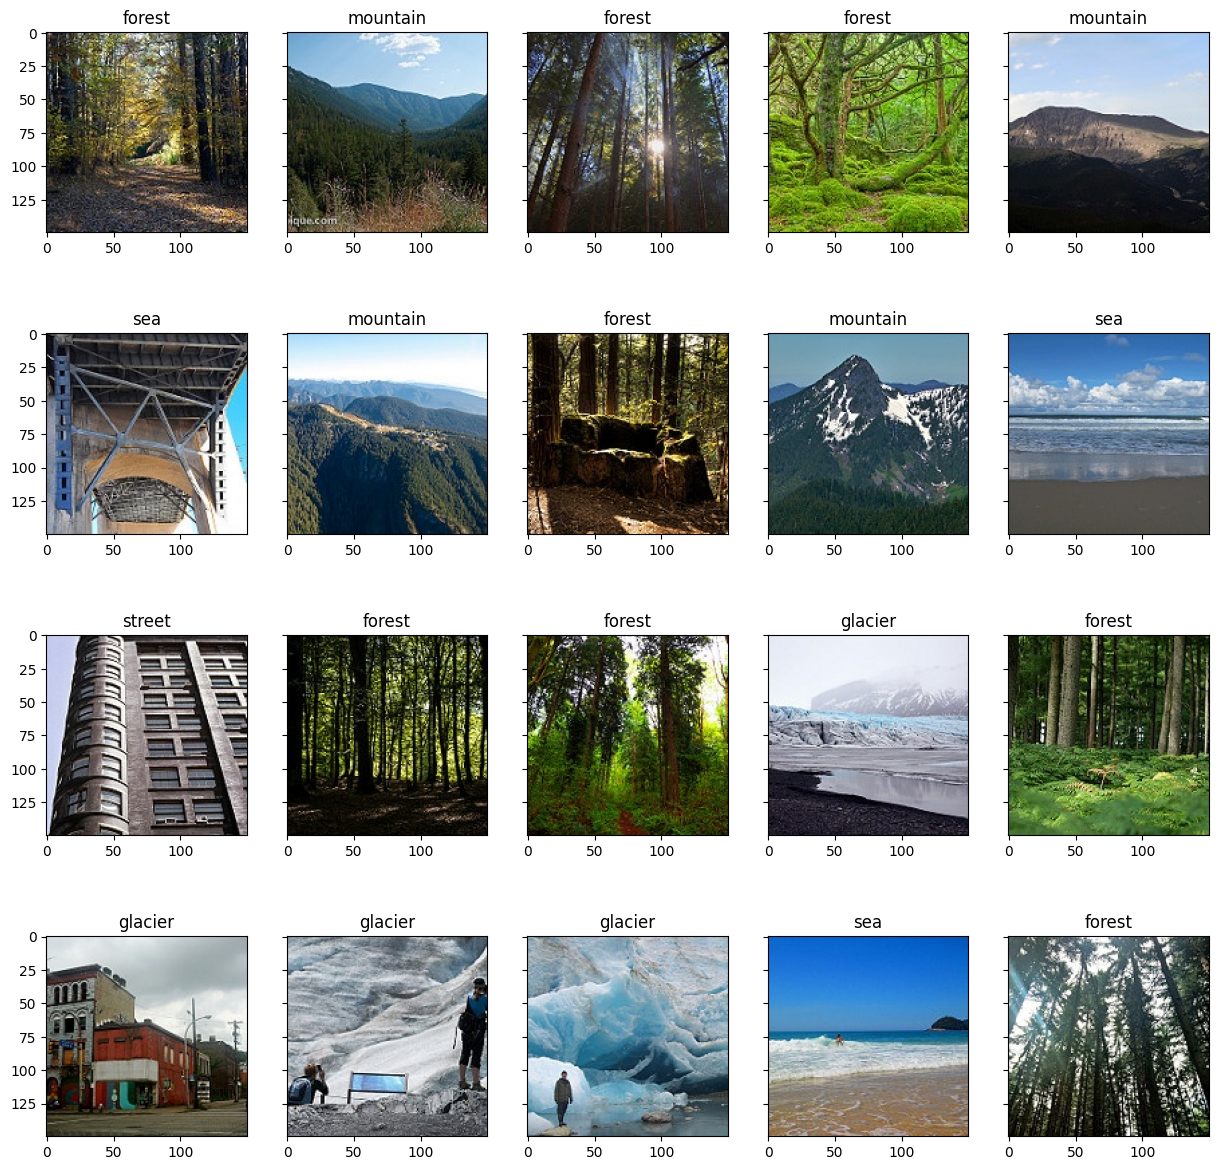

In [19]:
fig, axs = plt.subplots(4,5, figsize=(15, 15), sharey=True)


idx_l = 0
idx_h = 5

for i in range(4):
    idx_ax = 0  
    for j in range(idx_l,idx_h):
        inputs_pred[j-1] = inputs_pred[j-1]/2 + 0.5 #undo normalize
        im = inputs_pred[j-1]
        im = im.cpu().data.numpy()
        axs[i][idx_ax].imshow(np.transpose(im, (1,2,0)))
        axs[i][idx_ax].title.set_text(labels_predicted[j-1])
        idx_ax+=1
    idx_l += 5
    idx_h += 5
plt.show()